<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/AI%20study/%EC%B9%98%EC%95%84/tooth_CNN_predict_210724.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 틀

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets, layers, models

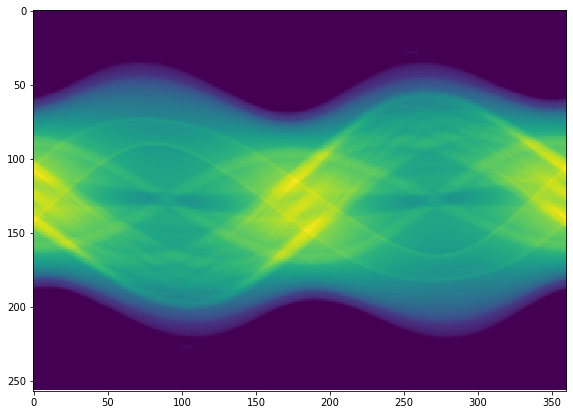

In [ ]:
df = pd.read_table('./images/sino0.txt',sep='\t', header = None).T
plt.figure(figsize = (15, 7))
plt.imshow(df)
plt.colorbar;

In [ ]:
df.shape # 왜 256이 아니라 257이징?... train 과정에는 영향 없어서 pass

(257, 360)

훈련 데이터 :  

                가로 : 6개

                세로 : 총 6개 ( 120 위로 3개, 125 아래로 3개 )

                데이터 개수 : 360 - 6

                형태 : 354 * 6 * 6

In [ ]:
pd.concat([df.iloc[117:120, 0:6], df.iloc[125:128, 0:6]], axis = 0)

,0,1,2,3,4,5
117,231.0,230.0,232.0,231.0,232.0,235.0
118,229.0,229.0,228.0,231.0,230.0,231.0
119,233.0,231.0,229.0,228.0,230.0,229.0
125,250.0,248.0,251.0,251.0,249.0,245.0
126,249.0,249.0,248.0,250.0,251.0,249.0
127,245.0,248.0,248.0,247.0,250.0,249.0


예측 데이터 :  

                가로 : 1개 ( 훈련 데이터 가로 6개 중 (6/2)+1번째 -> 4번째 )

                세로 : 5개

                형태 : 5

In [ ]:
pd.DataFrame(df.iloc[120:125, 3])

,3
120,231.0
121,236.0
122,241.0
123,244.0
124,249.0


데이터 형태.

train 344개, test 10개 -> 데이터 개수 많이 부족함.

수정 필요.

In [ ]:
# train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

# X 형태 (6, 6), y 형태 (6)
for i in range(360 - 6):
  if i > 170 and i <= 180:
    X_test_org.append(pd.concat([df.iloc[117:120, 0+i:6+i], df.iloc[125:128, 0+i:6+i]], axis = 0))
    y_test_org.append(df.iloc[120:125, i+int(6/2)])
  else:
    X_train_org.append(pd.concat([df.iloc[117:120, 0+i:6+i], df.iloc[125:128, 0+i:6+i]], axis = 0))
    y_train_org.append(df.iloc[120:125, i+int(6/2)])

# np.array 형태로 변환 합니다.
X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

# RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
# train 형태 : ((344, 6, 6, 1)), test 형태 : ((10, 6, 6, 1))
# tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
X_train = X_train_org.reshape((344, 6, 6, 1))
X_test = X_test_org.reshape((10, 6, 6, 1))
y_train = y_train_org
y_test = y_test_org

# 픽셀 값을 0~1 사이로 정규화합니다.
X_train, X_test, y_train, y_test = X_train / 300.0, X_test / 300.0, y_train / 300.0, y_test / 300.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((344, 6, 6, 1), (10, 6, 6, 1), (344, 5), (10, 5))

모델 형태 만드는 부분.

데이터 형태(6, 6, 1)가 작다 보니 filter가 작아짐.

수정 필요.

이부분 수정에 따라 많이 결과가 바뀝니당 !

주석 처리 되어 있는 부분이 중간중간 지저분하게 있어서 읽고 나면 지우고 보시는게 깔끔해 보일겁니다 !

In [ ]:
model = models.Sequential()
# Conv2D(feature, filter, activation, input_shape)
# feature 수만큼 그림을 만듦
# input_shape의 형태에서 filter 값의 -1 만큼 줄어든 상태로 output이 나옴
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(6, 6, 1)))
# MaxPooling2D(filter)
# filter안의 최대값을 추출해서 크기를 줄임. 저희는 안해도 될듯!
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((1, 1)))
# model.add(layers.Conv2D(64, (1, 1), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 4, 4, 32)          320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 35,589
Trainable params: 35,589
Non-trainable params: 0
_________________________________________________________________


모델 구성은 우선 adam, mse를 사용.

epoch 값 올리고 loss 부분도..

수정 필요

예측 결과 값을 어떻게 라벨링 해야 할지 고민해봐야 될 것 같습니다.

https://www.tensorflow.org/api_docs/python/tf/keras/losses

loss에 들어갈 수 있는 함수들 모은 사이트 입니다.

In [ ]:
# model 구성
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

model.fit(X_test, y_test, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.4316e-05 - accuracy: 0.8000
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.2000
Epoch 3/1000
1/1 [==============================] - 0s 975us/step - loss: 0.0013 - accuracy: 0.2000
Epoch 4/1000
1/1 [==============================] - 0s 976us/step - loss: 0.0063 - accuracy: 0.2000
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.8000
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.8000
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.8000
Epoch 8/1000
1/1 [==============================] - 0s 976us/step - loss: 0.0025 - accuracy: 0.8000
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.8000
Epoch 10/1000
1/1 [==============================] - 0s 977us/step - loss: 0.0021 - accuracy: 0.2000
Epoch 1

1/1 [==============================] - 0s 2ms/step - loss: 2.9050e-05 - accuracy: 0.8000
Epoch 159/1000
1/1 [==============================] - 0s 975us/step - loss: 2.8973e-05 - accuracy: 0.8000
Epoch 160/1000
1/1 [==============================] - 0s 975us/step - loss: 2.8896e-05 - accuracy: 0.8000
Epoch 161/1000
1/1 [==============================] - 0s 976us/step - loss: 2.8820e-05 - accuracy: 0.8000
Epoch 162/1000
1/1 [==============================] - 0s 976us/step - loss: 2.8743e-05 - accuracy: 0.8000
Epoch 163/1000
1/1 [==============================] - 0s 976us/step - loss: 2.8667e-05 - accuracy: 0.8000
Epoch 164/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.8590e-05 - accuracy: 0.8000
Epoch 165/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.8515e-05 - accuracy: 0.8000
Epoch 166/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.8439e-05 - accuracy: 0.8000
Epoch 167/1000
1/1 [==============================] - 0s 976us/step -

1/1 [==============================] - 0s 976us/step - loss: 1.9917e-05 - accuracy: 0.8000
Epoch 314/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.9876e-05 - accuracy: 0.8000
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.9836e-05 - accuracy: 0.8000
Epoch 316/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.9796e-05 - accuracy: 0.8000
Epoch 317/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.9757e-05 - accuracy: 0.8000
Epoch 318/1000
1/1 [==============================] - 0s 976us/step - loss: 1.9717e-05 - accuracy: 0.8000
Epoch 319/1000
1/1 [==============================] - 0s 975us/step - loss: 1.9678e-05 - accuracy: 0.8000
Epoch 320/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.9639e-05 - accuracy: 0.8000
Epoch 321/1000
1/1 [==============================] - 0s 974us/step - loss: 1.9600e-05 - accuracy: 0.8000
Epoch 322/1000
1/1 [==============================] - 0s 975us/step - l

1/1 [==============================] - 0s 976us/step - loss: 1.5746e-05 - accuracy: 0.8000
Epoch 468/1000
1/1 [==============================] - 0s 976us/step - loss: 1.5729e-05 - accuracy: 0.8000
Epoch 469/1000
1/1 [==============================] - 0s 975us/step - loss: 1.5713e-05 - accuracy: 0.8000
Epoch 470/1000
1/1 [==============================] - 0s 975us/step - loss: 1.5696e-05 - accuracy: 0.8000
Epoch 471/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5679e-05 - accuracy: 0.8000
Epoch 472/1000
1/1 [==============================] - 0s 976us/step - loss: 1.5663e-05 - accuracy: 0.8000
Epoch 473/1000
1/1 [==============================] - 0s 976us/step - loss: 1.5646e-05 - accuracy: 0.8000
Epoch 474/1000
1/1 [==============================] - 0s 975us/step - loss: 1.5630e-05 - accuracy: 0.8000
Epoch 475/1000
1/1 [==============================] - 0s 975us/step - loss: 1.5614e-05 - accuracy: 0.8000
Epoch 476/1000
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 2ms/step - loss: 1.3912e-05 - accuracy: 0.8000
Epoch 622/1000
1/1 [==============================] - 0s 975us/step - loss: 1.3903e-05 - accuracy: 0.8000
Epoch 623/1000
1/1 [==============================] - 0s 976us/step - loss: 1.3894e-05 - accuracy: 0.8000
Epoch 624/1000
1/1 [==============================] - 0s 976us/step - loss: 1.3886e-05 - accuracy: 0.8000
Epoch 625/1000
1/1 [==============================] - 0s 975us/step - loss: 1.3877e-05 - accuracy: 0.8000
Epoch 626/1000
1/1 [==============================] - 0s 976us/step - loss: 1.3868e-05 - accuracy: 0.8000
Epoch 627/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3860e-05 - accuracy: 0.8000
Epoch 628/1000
1/1 [==============================] - 0s 0s/step - loss: 1.3852e-05 - accuracy: 0.8000
Epoch 629/1000
1/1 [==============================] - 0s 0s/step - loss: 1.3843e-05 - accuracy: 0.8000
Epoch 630/1000
1/1 [==============================] - 0s 977us/step - l

1/1 [==============================] - 0s 0s/step - loss: 1.2761e-05 - accuracy: 0.8000
Epoch 776/1000
1/1 [==============================] - 0s 976us/step - loss: 1.2754e-05 - accuracy: 0.8000
Epoch 777/1000
1/1 [==============================] - 0s 976us/step - loss: 1.2747e-05 - accuracy: 0.8000
Epoch 778/1000
1/1 [==============================] - 0s 975us/step - loss: 1.2741e-05 - accuracy: 0.8000
Epoch 779/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.2734e-05 - accuracy: 0.8000
Epoch 780/1000
1/1 [==============================] - 0s 975us/step - loss: 1.2727e-05 - accuracy: 0.8000
Epoch 781/1000
1/1 [==============================] - 0s 977us/step - loss: 1.2720e-05 - accuracy: 0.8000
Epoch 782/1000
1/1 [==============================] - 0s 974us/step - loss: 1.2714e-05 - accuracy: 0.8000
Epoch 783/1000
1/1 [==============================] - 0s 975us/step - loss: 1.2707e-05 - accuracy: 0.8000
Epoch 784/1000
1/1 [==============================] - 0s 2ms/step 

1/1 [==============================] - 0s 975us/step - loss: 1.1781e-05 - accuracy: 0.8000
Epoch 930/1000
1/1 [==============================] - 0s 975us/step - loss: 1.1775e-05 - accuracy: 0.8000
Epoch 931/1000
1/1 [==============================] - 0s 976us/step - loss: 1.1769e-05 - accuracy: 0.8000
Epoch 932/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1763e-05 - accuracy: 0.8000
Epoch 933/1000
1/1 [==============================] - 0s 976us/step - loss: 1.1757e-05 - accuracy: 0.8000
Epoch 934/1000
1/1 [==============================] - 0s 975us/step - loss: 1.1751e-05 - accuracy: 0.8000
Epoch 935/1000
1/1 [==============================] - 0s 975us/step - loss: 1.1745e-05 - accuracy: 0.8000
Epoch 936/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1739e-05 - accuracy: 0.8000
Epoch 937/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1733e-05 - accuracy: 0.8000
Epoch 938/1000
1/1 [==============================] - 0s 976us/step

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc

1/1 - 0s - loss: 1.1353e-05 - accuracy: 0.8000


In [ ]:
print(test_acc)   # 정확도

0.800000011920929


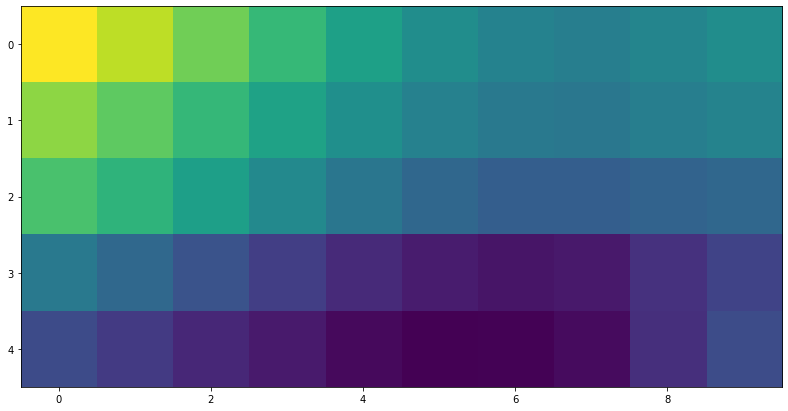

In [ ]:
# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.
plt.figure(figsize = (15, 7))
plt.imshow(pred.T)
plt.colorbar;

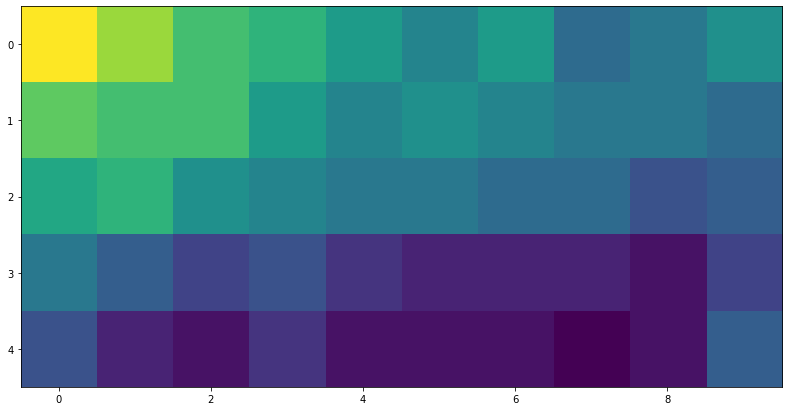

In [ ]:
# 예측 결과 확인
plt.figure(figsize = (15, 7))
plt.imshow(y_test_org.T)        # 예측 결과 값을 () 안에 넣으면 됩니다.
plt.colorbar;

# 위에 수정 후 결과 좋으면 아래 진행 하겠습니다.

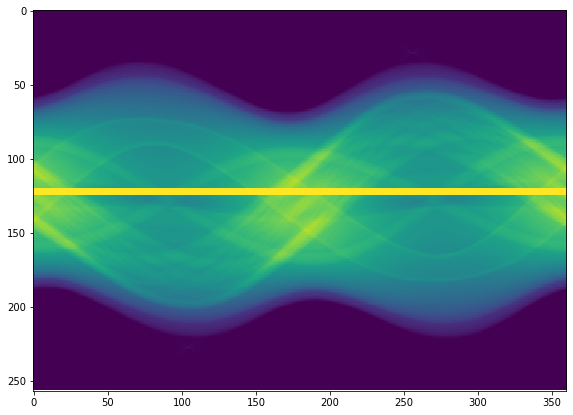

In [ ]:
df_test = pd.read_table('./images/sino0.txt',sep='\t', header = None).T
df_test.iloc[120:125, :] = 300
plt.figure(figsize = (15, 7))
plt.imshow(df_test)
plt.colorbar;

In [ ]:
pd.concat([df_test.iloc[117:120, 0:5], df_test.iloc[125:128, 0:5]], axis = 0)

,0,1,2,3,4
117,231.0,230.0,232.0,231.0,232.0
118,229.0,229.0,228.0,231.0,230.0
119,233.0,231.0,229.0,228.0,230.0
125,250.0,248.0,251.0,251.0,249.0
126,249.0,249.0,248.0,250.0,251.0
127,245.0,248.0,248.0,247.0,250.0


In [ ]:
df_test.iloc[120:125, 0:5]

,0,1,2,3,4
120,300.0,300.0,300.0,300.0,300.0
121,300.0,300.0,300.0,300.0,300.0
122,300.0,300.0,300.0,300.0,300.0
123,300.0,300.0,300.0,300.0,300.0
124,300.0,300.0,300.0,300.0,300.0


In [ ]:
# test 할 부분만 가져와서 예측해보겠습니다.
# 노란 부분을 다 가져와서 예측해보겠습니다.
X_test_test = []

# X 형태 (6, 6)
for i in range(360 - 6):
    X_test_test.append(pd.concat([df.iloc[117:120, 0+i:6+i], df.iloc[125:128, 0+i:6+i]], axis = 0))

# np.array 형태로 변환 합니다.
X_test_test = np.array(X_test_test)

# test 부분만 가져와서 예측하겠습니다.
X_test = X_test_test.reshape((354, 6, 6, 1))

# 픽셀 값을 0~1 사이로 정규화합니다.
X_test = X_test / 300.0

X_test.shape

(354, 6, 6, 1)

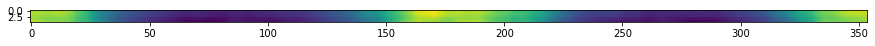

In [ ]:
# 위에서 트레이닝 한 모델에 예측 시키겠습니다.
pred_test = model.predict(X_test)

# 시각화
plt.figure(figsize = (15, 7))
plt.imshow(pred_test.T)
plt.colorbar;

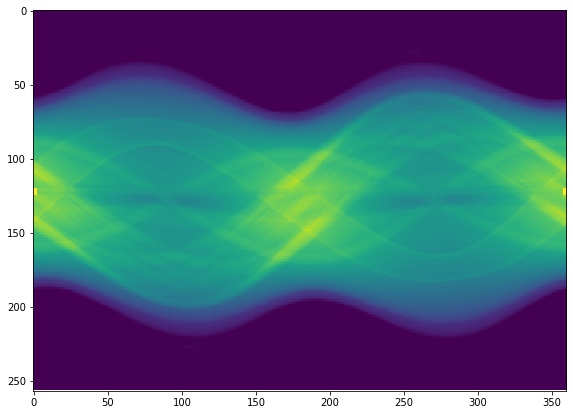

In [ ]:
# 예측한 이미지를 추가해서 그림을 그려보도록 하겠습니다. 
# 위에서 정규화를 했기 때문에 예측 모델에 300을 곱해줘야 합니다.
df_test.iloc[120:125, 3:357] = pred_test.T * 300.0
# 시각화
plt.figure(figsize = (15, 7))
plt.imshow(df_test)
plt.colorbar;

양 옆 3개는 ![image.png](attachment:image.png) 이런식으로 예측 하다 보니 양 옆에 3개씩 빈 공간이 생기더라고요 ㅠㅠ

양 옆 3개를 우선 원본 이미지로 대체 해보겠습니다.

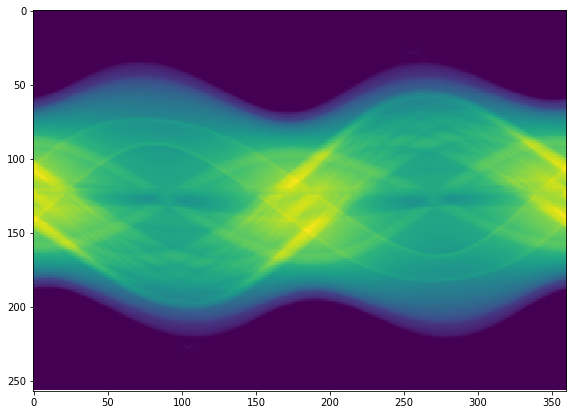

In [ ]:
# 양 옆 3개를 우선 원본 이미지로 대체 해보겠습니다.
df_test = pd.read_table('./images/sino0.txt',sep='\t', header = None).T
df_test.iloc[120:125, 3:357] = 300

pred_test = model.predict(X_test)
df_test.iloc[120:125, 3:357] = pred_test.T * 300.0

# 시각화
plt.figure(figsize = (15, 7))
plt.imshow(df_test)
plt.colorbar;